In [1]:
import os
os.environ["PYTORCH_ENABLE_MPS_FALLBACK"] = "1"

### Plots Time Series

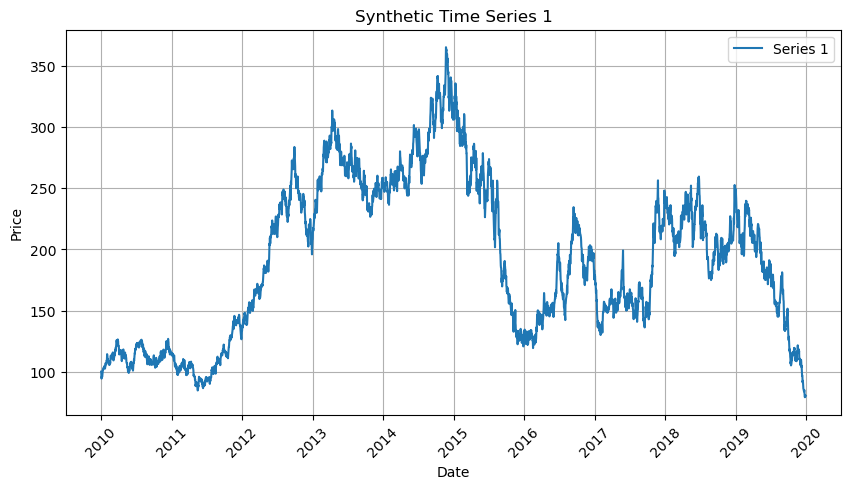

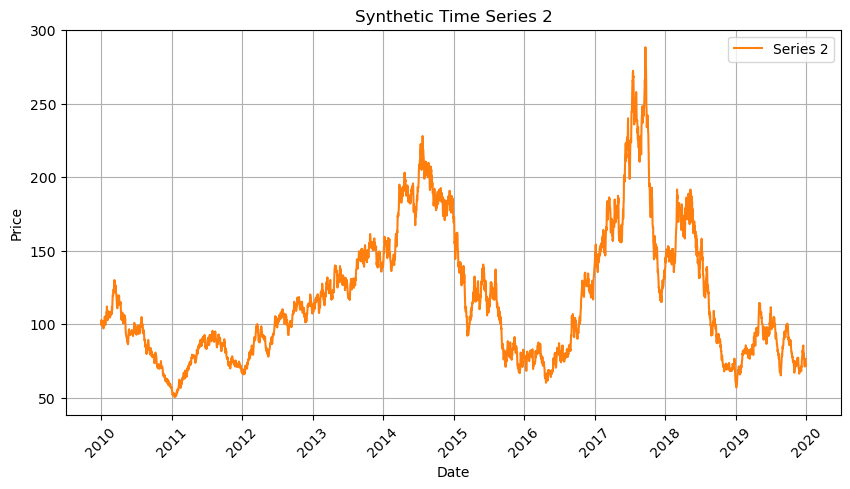

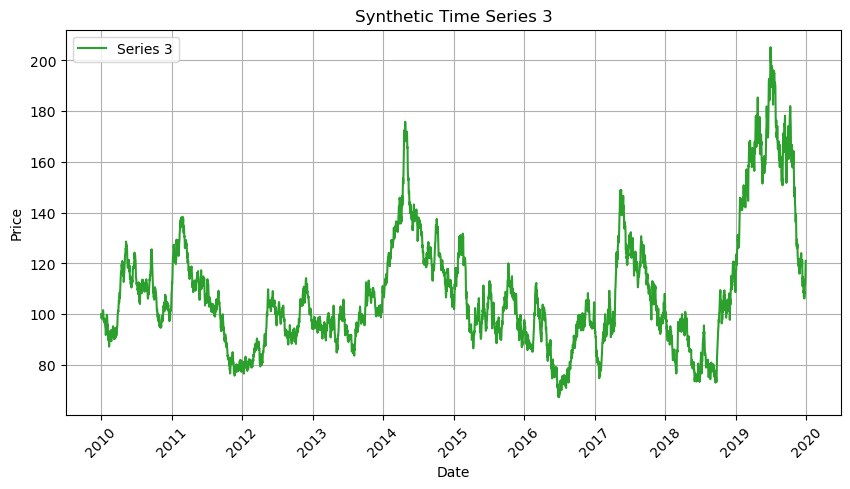

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import os

# Folder where the CSV files are stored
DATA_FOLDER = "data/synthetic/data"

# List of CSV files for the first three synthetic series
csv_files = [os.path.join(DATA_FOLDER, f"synthetic_series_{i+1}.csv") for i in range(3)]

# Function to read and plot synthetic time series separately
def plot_synthetic_series_separate(csv_files):
    for i, csv_file in enumerate(csv_files):
        if os.path.exists(csv_file):
            # Read CSV
            df = pd.read_csv(csv_file, parse_dates=["Date"])

            # Create a new figure for each series
            plt.figure(figsize=(10, 5))
            plt.plot(df["Date"], df["Price"], label=f"Series {i+1}", color=f"C{i}")

            # Formatting
            plt.xlabel("Date")
            plt.ylabel("Price")
            plt.title(f"Synthetic Time Series {i+1}")
            plt.legend()
            plt.xticks(rotation=45)
            plt.grid(True)
            plt.show()
        else:
            print(f"⚠️ Warning: {csv_file} not found. Skipping...")

# Plot each series separately
plot_synthetic_series_separate(csv_files)


LSTM + LSTM with Attention Baseline

Epoch 0, Loss: 0.016746
Epoch 10, Loss: 0.000481
Epoch 20, Loss: 0.000280
Epoch 30, Loss: 0.000223
Epoch 40, Loss: 0.000238
Epoch 50, Loss: 0.000217
Epoch 60, Loss: 0.000211
Epoch 70, Loss: 0.000211
Epoch 80, Loss: 0.000212
Epoch 90, Loss: 0.000211


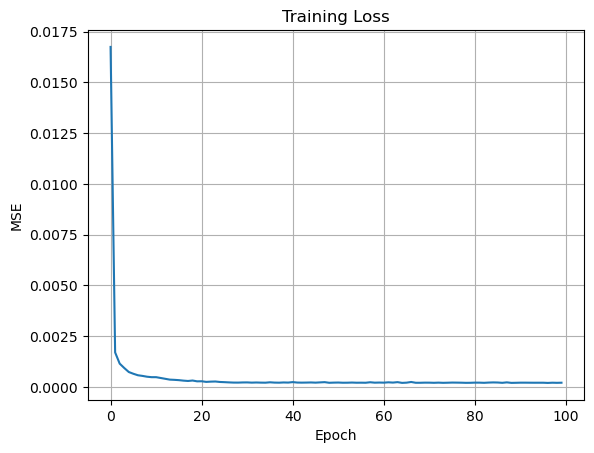

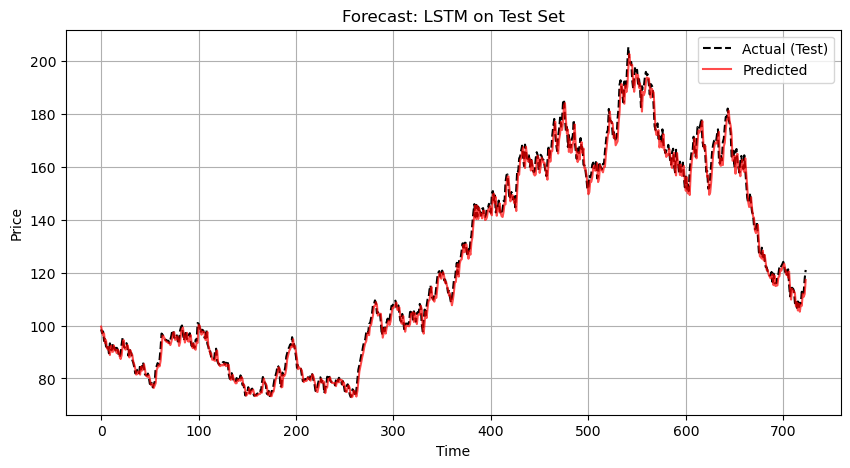

In [9]:
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import MinMaxScaler
from models.lstm import LSTMModel
# from models.lstm_attention import LSTMWithAttention

# 📥 Load data
df = pd.read_csv("data/synthetic/data/synthetic_series_3.csv")
prices = df["Price"].values.reshape(-1, 1)

# ⚖️ Normalize prices
scaler = MinMaxScaler()
prices_scaled = scaler.fit_transform(prices)

# ⚙️ Hyperparameters
seq_len = 30
input_size = 1
hidden_size = 64
batch_size = 32
epochs = 100
lr = 0.001

# 🔁 Create sequences
X = [prices_scaled[i:i+seq_len] for i in range(len(prices_scaled) - seq_len)]
Y = [prices_scaled[i+seq_len] for i in range(len(prices_scaled) - seq_len)]

X = torch.tensor(X, dtype=torch.float32)
Y = torch.tensor(Y, dtype=torch.float32)

# 🧪 Train-test split
split_idx = int(len(X) * 0.8)
X_train, Y_train = X[:split_idx], Y[:split_idx]
X_test, Y_test = X[split_idx:], Y[split_idx:]

# 📦 Dataloaders
train_dataset = TensorDataset(X_train, Y_train)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# 🧠 Initialize model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = LSTMModel(input_size=input_size, hidden_size=hidden_size).to(device)
# model = LSTMWithAttention(input_size=input_size, hidden_size=hidden_size).to(device)

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=lr)

# 🏋️ Training
losses = []
for epoch in range(epochs):
    epoch_loss = 0
    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)
        optimizer.zero_grad()
        preds = model(xb)
        loss = criterion(preds, yb)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    losses.append(epoch_loss / len(train_loader))
    if epoch % 10 == 0:
        print(f"Epoch {epoch}, Loss: {losses[-1]:.6f}")

# 📉 Plot training loss
plt.plot(losses)
plt.title("Training Loss")
plt.xlabel("Epoch")
plt.ylabel("MSE")
plt.grid(True)
plt.show()

# 🔮 Test predictions
model.eval()
with torch.no_grad():
    test_preds = model(X_test.to(device)).cpu().numpy()
    actual = Y_test.numpy()

# 🔄 Inverse transform to original scale
test_preds_rescaled = scaler.inverse_transform(test_preds)
actual_rescaled = scaler.inverse_transform(actual)

# 📈 Plot
plt.figure(figsize=(10, 5))
plt.plot(actual_rescaled, label="Actual (Test)", linestyle="dashed", color="black")
plt.plot(test_preds_rescaled, label="Predicted", color="red", alpha=0.7)
plt.title("Forecast: LSTM on Test Set")
plt.xlabel("Time")
plt.ylabel("Price")
plt.legend()
plt.grid(True)
plt.show()


In [10]:
from sklearn.metrics import mean_absolute_error, r2_score

# 🔮 Get training predictions
with torch.no_grad():
    train_preds = model(X_train.to(device)).cpu().numpy()
    train_actual = Y_train.numpy()

# 🔄 Inverse transform
train_preds_rescaled = scaler.inverse_transform(train_preds)
train_actual_rescaled = scaler.inverse_transform(train_actual)

# 📊 Calculate Metrics
train_mae = mean_absolute_error(train_actual_rescaled, train_preds_rescaled)
train_r2 = r2_score(train_actual_rescaled, train_preds_rescaled)

test_mae = mean_absolute_error(actual_rescaled, test_preds_rescaled)
test_r2 = r2_score(actual_rescaled, test_preds_rescaled)

# 📢 Print
print("\n📊 Training Metrics")
print("  MAE: ", round(train_mae, 4))
print("  R²:  ", round(train_r2, 4))

print("\n📊 Testing Metrics")
print("  MAE: ", round(test_mae, 4))
print("  R²:  ", round(test_r2, 4))



📊 Training Metrics
  MAE:  1.6179
  R²:   0.9854

📊 Testing Metrics
  MAE:  2.4274
  R²:   0.993


Epoch 0, Loss: 10864.1726
Epoch 10, Loss: 2066.1193
Epoch 20, Loss: 639.5889
Epoch 30, Loss: 219.5723
Epoch 40, Loss: 89.7422


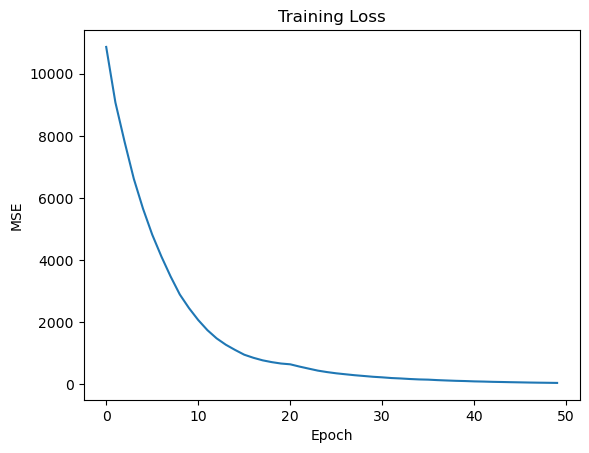

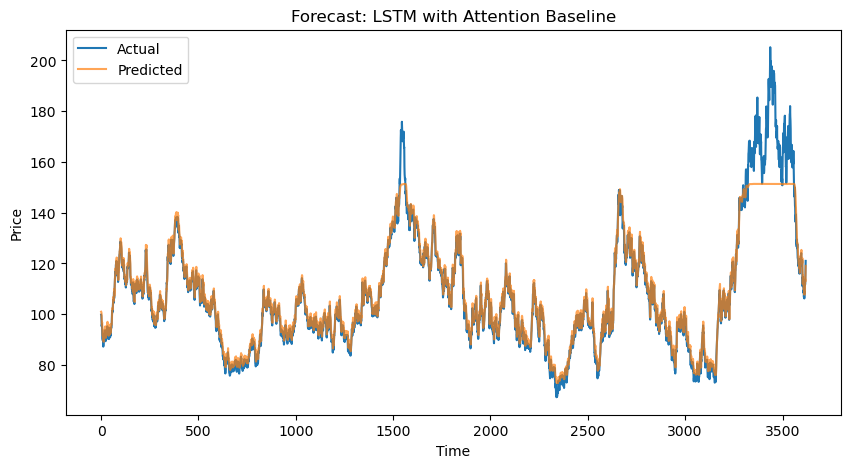

In [15]:
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, TensorDataset
# from models.lstm import LSTMModel
from models.lstm_attention import LSTMWithAttention

# Load synthetic data
df = pd.read_csv("data/synthetic/data/synthetic_series_3.csv")
prices = df["Price"].values

# Hyperparameters
seq_len = 30
input_size = 1
hidden_size = 64
batch_size = 32
epochs = 50
lr = 0.001

# Create sequences
X = [prices[i:i+seq_len] for i in range(len(prices) - seq_len)]
Y = [prices[i+seq_len] for i in range(len(prices) - seq_len)]

X = torch.tensor(X, dtype=torch.float32).unsqueeze(-1)
Y = torch.tensor(Y, dtype=torch.float32).unsqueeze(-1)

# Dataloader
train_dataset = TensorDataset(X, Y)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# Initialize model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# model = LSTMModel(input_size=input_size, hidden_size=hidden_size).to(device)
model = LSTMWithAttention(input_size=input_size, hidden_size=hidden_size).to(device)

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=lr)

# Train
losses = []
for epoch in range(epochs):
    epoch_loss = 0
    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)
        optimizer.zero_grad()
        preds = model(xb)
        loss = criterion(preds, yb)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    losses.append(epoch_loss / len(train_loader))
    if epoch % 10 == 0:
        print(f"Epoch {epoch}, Loss: {losses[-1]:.4f}")

# Plot training loss
plt.plot(losses)
plt.title("Training Loss")
plt.xlabel("Epoch")
plt.ylabel("MSE")
plt.show()

# Test
model.eval()
with torch.no_grad():
    preds = model(X.to(device)).cpu().numpy()

# Plot predictions
plt.figure(figsize=(10, 5))
plt.plot(Y.numpy(), label="Actual")
plt.plot(preds, label="Predicted", alpha=0.7)
plt.legend()
plt.title("Forecast: LSTM with Attention Baseline")
plt.xlabel("Time")
plt.ylabel("Price")
plt.show()


In [16]:
from sklearn.metrics import mean_absolute_error, r2_score

# 🔀 Split again for evaluation (in case you didn’t already save them)
split_idx = int(len(X) * 0.8)
X_train_eval, Y_train_eval = X[:split_idx], Y[:split_idx]
X_test_eval, Y_test_eval = X[split_idx:], Y[split_idx:]

# 📈 Generate predictions
model.eval()
with torch.no_grad():
    train_preds = model(X_train_eval.to(device)).cpu().numpy()
    test_preds = model(X_test_eval.to(device)).cpu().numpy()

# 🔄 Inverse transform
train_actual = scaler.inverse_transform(Y_train_eval.numpy())
train_preds_rescaled = scaler.inverse_transform(train_preds)

test_actual = scaler.inverse_transform(Y_test_eval.numpy())
test_preds_rescaled = scaler.inverse_transform(test_preds)

# 📊 Compute metrics
train_mae = mean_absolute_error(train_actual, train_preds_rescaled)
train_r2 = r2_score(train_actual, train_preds_rescaled)
test_mae = mean_absolute_error(test_actual, test_preds_rescaled)
test_r2 = r2_score(test_actual, test_preds_rescaled)

# 📢 Print results
print("\n📊 Training Metrics")
print(f"  MAE:  {train_mae:.4f}")
print(f"  R²:   {train_r2:.4f}")

print("\n📊 Testing Metrics")
print(f"  MAE:  {test_mae:.4f}")
print(f"  R²:   {test_r2:.4f}")



📊 Training Metrics
  MAE:  272.3147
  R²:   0.9726

📊 Testing Metrics
  MAE:  1055.5669
  R²:   0.8834


### NBEATSX V1


🔄 Training on data/synthetic/data/synthetic_series_10.csv...

Epoch 0/50 - Loss: 285.8291
Epoch 10/50 - Loss: 3.2165
Epoch 20/50 - Loss: 2.9505
Epoch 30/50 - Loss: 4.0678
Epoch 40/50 - Loss: 4.3830
Accuracy:  0.4723756906077348


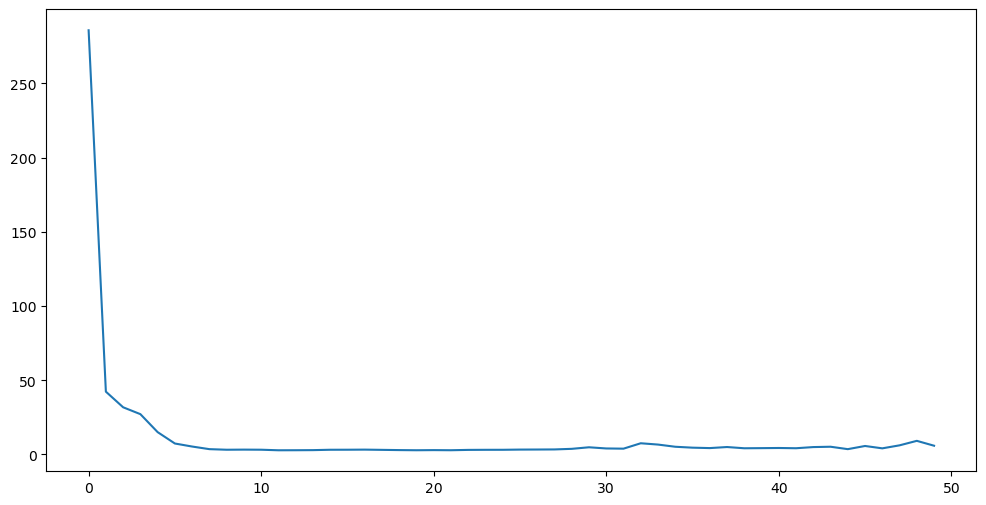

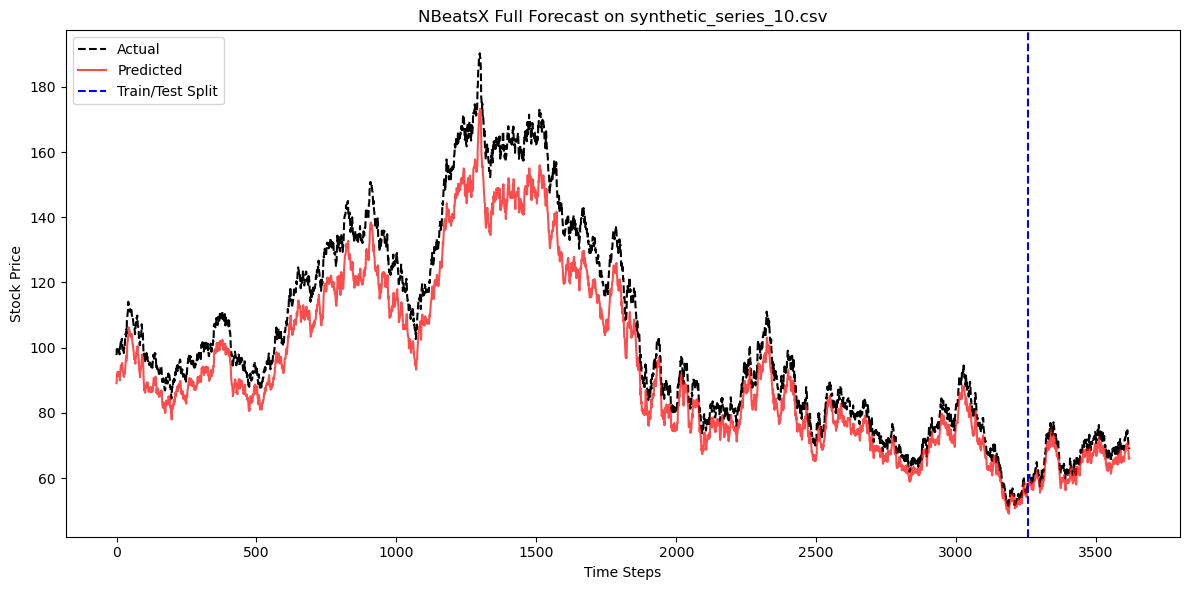

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from models.nbeatsx import NBeatsX  # Ensure correct import
import importlib
import models
importlib.reload(models)

# 🛠 Load Synthetic Data (3 CSV Files)
# data_files = ["data/synthetic/synthetic_series_1.csv", "data/synthetic/synthetic_series_2.csv", "data/synthetic/synthetic_series_3.csv"]
data_files = ["data/synthetic/data/synthetic_series_10.csv"]

# 📌 Model Parameters
input_size = 30  # Lookback window
exog_size = 3    # Example: market index, volatility, economic indicators
output_size = 1  # Predicting next time step
hidden_units = 256
num_blocks = 3
epochs = 50
batch_size = 32
learning_rate = 0.001

# 🚀 Device Configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 📌 Data Preprocessing Function
def prepare_data(df, input_size, exog_size):
    prices = df["Price"].values
    dates = df["Date"].values
    
    # Generate exogenous factors (randomized for testing)
    np.random.seed(42)
    exog_factors = np.random.uniform(0.9, 1.1, size=(len(prices), exog_size))

    X, Y, Y_labels, Exog, last_x = [], [], [], [], []
    for i in range(len(prices) - input_size):
        X.append(prices[i:i+input_size])
        last_x.append(prices[i+input_size-1])
        Y.append(prices[i+input_size])  # Predict next time step
        Exog.append(exog_factors[i+input_size])  # Exog data aligns with target
        if prices[i+input_size] > prices[i+input_size-1]:
            Y_labels.append(0)
        else:
            Y_labels.append(1)
    # Convert to Tensors
    X, Y, Exog = map(lambda x: torch.tensor(x, dtype=torch.float32), (X, Y, Exog))
    
    return X, Y.unsqueeze(1), Y_labels, Exog, last_x  # Ensure correct shape for training

# 🚀 Training Loop
def train_model(model, X_train, Y_train, Exog_train, epochs, batch_size, lr):
    model.to(device)
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)
    
    losses = []
    for epoch in range(epochs):
        epoch_loss = 0
        for i in range(0, len(X_train), batch_size):
            x_batch = X_train[i:i+batch_size].to(device)
            y_batch = Y_train[i:i+batch_size].to(device)
            exog_batch = Exog_train[i:i+batch_size].to(device)
            
            optimizer.zero_grad()
            preds = model(x_batch, exog_batch)
            loss = criterion(preds, y_batch)
            loss.backward()
            optimizer.step()
            
            epoch_loss += loss.item()
        
        avg_loss = epoch_loss / (len(X_train) // batch_size)
        losses.append(avg_loss)
        if epoch % 10 == 0:
            print(f"Epoch {epoch}/{epochs} - Loss: {avg_loss:.4f}")
    
    return losses

# 🚀 Train & Evaluate on Each Dataset
plt.figure(figsize=(12, 6))

for idx, file in enumerate(data_files):
    print(f"\n🔄 Training on {file}...\n")
    
    # 📌 Load & Prepare Data
    df = pd.read_csv(file)
    X, Y, Y_labels, Exog, last_x = prepare_data(df, input_size, exog_size)
    split_idx = int(len(X) * 0.9)
    X_train, Y_train, Y_labels_train, Exog_train, last_x_train = X[:split_idx], Y[:split_idx], Y_labels[:split_idx], Exog[:split_idx], last_x[:split_idx]
    X_test, Y_test, Y_labels_test, Exog_test, last_x_test = X[split_idx:], Y[split_idx:], Y_labels[split_idx:], Exog[split_idx:], last_x[split_idx:]
    
    # 📌 Initialize Model
    model = models.nbeatsx.NBeatsX(input_size=input_size, exog_size=exog_size, output_size=output_size, num_blocks=num_blocks, hidden_units=hidden_units).to(device)
    
    # 📌 Train Model
    losses = train_model(model, X_train, Y_train, Exog_train, epochs, batch_size, learning_rate)
    
    # 📈 Plot Training Loss
    plt.plot(losses, label=f"Series {idx+1}")

    # Get train predictions
    model.eval()
    with torch.no_grad():
        train_preds = model(X_train.to(device), Exog_train.to(device)).cpu().numpy()
        test_preds = model(X_test.to(device), Exog_test.to(device)).cpu().numpy()

    correct = 0
    for i in range(len(test_preds)):
        label = 1
        if test_preds[i] > last_x_test[i]:
            label = 0
        if label == Y_labels_test[i]:
            correct += 1
    print('Accuracy: ', correct/len(test_preds))
    
    # Combine actual and predicted
    actual_full = np.concatenate([Y_train.numpy().flatten(), Y_test.numpy().flatten()])
    preds_full = np.concatenate([train_preds.flatten(), test_preds.flatten()])

    # Plot everything
    plt.figure(figsize=(12, 6))
    plt.plot(actual_full, label="Actual", linestyle="--", color="black")
    plt.plot(preds_full, label="Predicted", color="red", alpha=0.7)
    plt.axvline(x=split_idx, color="blue", linestyle="--", label="Train/Test Split")
    plt.xlabel("Time Steps")
    plt.ylabel("Stock Price")
    plt.title(f"NBeatsX Full Forecast on {file.split('/')[-1]}")
    plt.legend()
    plt.tight_layout()
    plt.show()



In [3]:
labels = Y_labels_test
unique, counts = np.unique(labels, return_counts=True)
counts = dict(zip(unique, counts))
print('Up', counts[0]/len(labels))
print('Down', counts[1]/len(labels))

Up 0.5276243093922652
Down 0.4723756906077348


NBEATSX V2 Test


🔄 Training on data/synthetic/data/synthetic_series_1.csv...

Epoch 0/50 - Loss: 527.5681
Epoch 10/50 - Loss: 21.4554
Epoch 20/50 - Loss: 19.6362
Epoch 30/50 - Loss: 35.0448
Epoch 40/50 - Loss: 12.9560
Accuracy:  0.5331491712707183


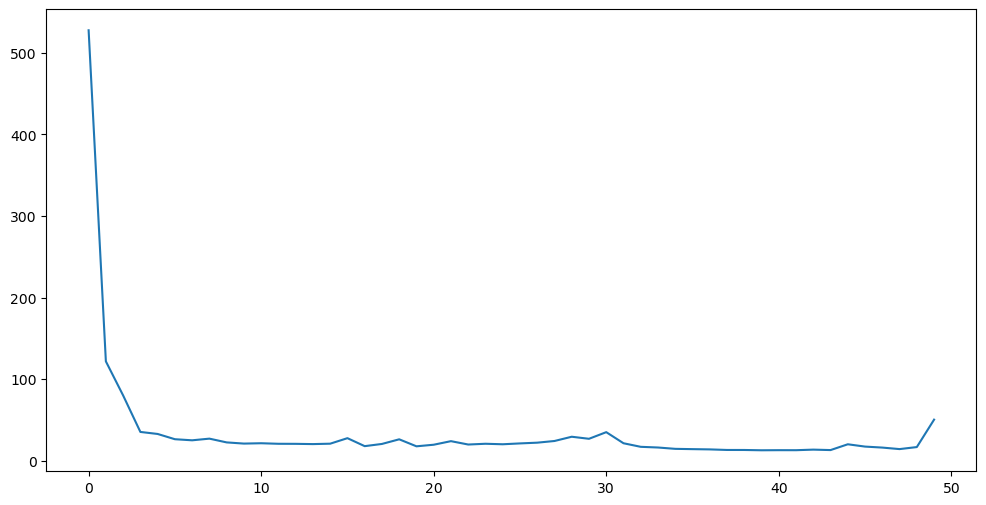

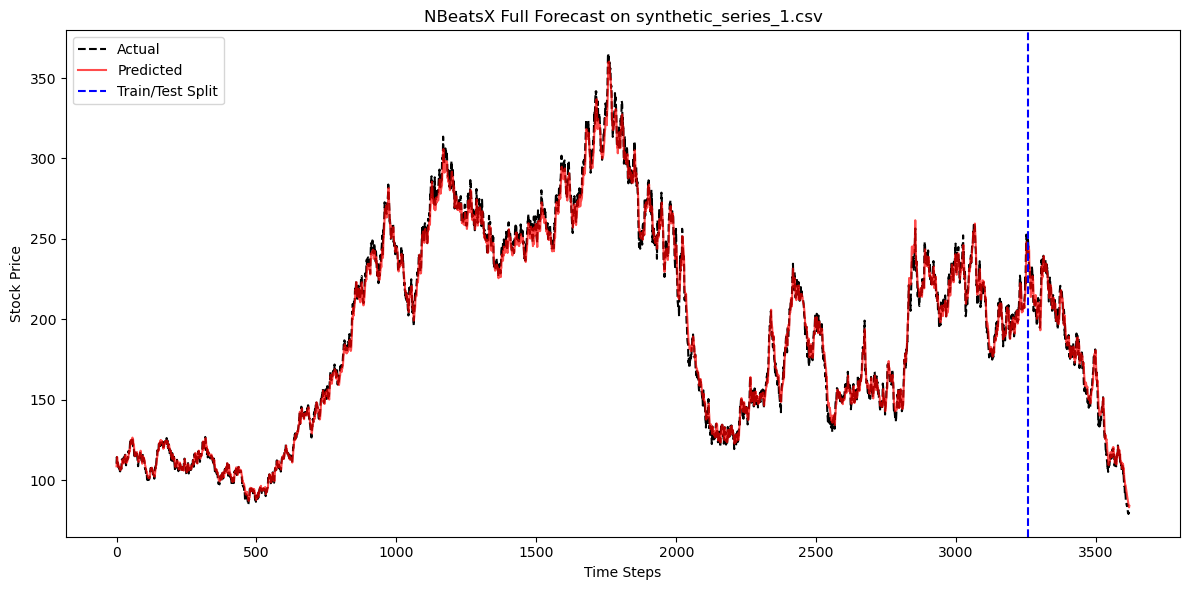

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from models.nbeatsx_v2 import NBeatsX  # Ensure correct import
import importlib
import models
importlib.reload(models)

# 🛠 Load Synthetic Data (3 CSV Files)
# data_files = ["data/synthetic/synthetic_series_1.csv", "data/synthetic/synthetic_series_2.csv", "data/synthetic/synthetic_series_3.csv"]
data_files = ["data/synthetic/data/synthetic_series_1.csv"]

# 📌 Model Parameters
input_size = 30  # Lookback window
exog_size = 3    # Example: market index, volatility, economic indicators
output_size = 1  # Predicting next time step
hidden_units = 256
num_blocks = 3
epochs = 50
batch_size = 32
learning_rate = 0.001

# 🚀 Device Configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 📌 Data Preprocessing Function
def prepare_data(df, input_size, exog_size):
    prices = df["Price"].values
    dates = df["Date"].values
    
    # Generate exogenous factors (randomized for testing)
    np.random.seed(42)
    exog_factors = np.random.uniform(0.9, 1.1, size=(len(prices), exog_size))

    X, Y, Y_labels, Exog, last_x = [], [], [], [], []
    for i in range(len(prices) - input_size):
        X.append(prices[i:i+input_size])
        last_x.append(prices[i+input_size-1])
        Y.append(prices[i+input_size])  # Predict next time step
        Exog.append(exog_factors[i+input_size])  # Exog data aligns with target
        if prices[i+input_size] > prices[i+input_size-1]:
            Y_labels.append(0)
        else:
            Y_labels.append(1)
    # Convert to Tensors
    X, Y, Exog = map(lambda x: torch.tensor(x, dtype=torch.float32), (X, Y, Exog))
    
    return X, Y.unsqueeze(1), Y_labels, Exog, last_x  # Ensure correct shape for training

# 🚀 Training Loop
def train_model(model, X_train, Y_train, Exog_train, epochs, batch_size, lr):
    model.to(device)
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)
    
    losses = []
    for epoch in range(epochs):
        epoch_loss = 0
        for i in range(0, len(X_train), batch_size):
            x_batch = X_train[i:i+batch_size].to(device)
            y_batch = Y_train[i:i+batch_size].to(device)
            exog_batch = Exog_train[i:i+batch_size].to(device)
            
            optimizer.zero_grad()
            preds = model(x_batch, exog_batch)
            loss = criterion(preds, y_batch)
            loss.backward()
            optimizer.step()
            
            epoch_loss += loss.item()
        
        avg_loss = epoch_loss / (len(X_train) // batch_size)
        losses.append(avg_loss)
        if epoch % 10 == 0:
            print(f"Epoch {epoch}/{epochs} - Loss: {avg_loss:.4f}")
    
    return losses

# 🚀 Train & Evaluate on Each Dataset
plt.figure(figsize=(12, 6))

for idx, file in enumerate(data_files):
    print(f"\n🔄 Training on {file}...\n")
    
    # 📌 Load & Prepare Data
    df = pd.read_csv(file)
    X, Y, Y_labels, Exog, last_x = prepare_data(df, input_size, exog_size)
    split_idx = int(len(X) * 0.9)
    X_train, Y_train, Y_labels_train, Exog_train, last_x_train = X[:split_idx], Y[:split_idx], Y_labels[:split_idx], Exog[:split_idx], last_x[:split_idx]
    X_test, Y_test, Y_labels_test, Exog_test, last_x_test = X[split_idx:], Y[split_idx:], Y_labels[split_idx:], Exog[split_idx:], last_x[split_idx:]
    
    # 📌 Initialize Model
    model = models.nbeatsx_v2.NBeatsX(input_size=input_size, exog_size=exog_size, num_blocks=num_blocks, hidden_units=hidden_units).to(device)
    
    # 📌 Train Model
    losses = train_model(model, X_train, Y_train, Exog_train, epochs, batch_size, learning_rate)
    
    # 📈 Plot Training Loss
    plt.plot(losses, label=f"Series {idx+1}")

    # Get train predictions
    model.eval()
    with torch.no_grad():
        train_preds = model(X_train.to(device), Exog_train.to(device)).cpu().numpy()
        test_preds = model(X_test.to(device), Exog_test.to(device)).cpu().numpy()

    correct = 0
    for i in range(len(test_preds)):
        label = 1
        if test_preds[i] > last_x_test[i]:
            label = 0
        if label == Y_labels_test[i]:
            correct += 1
    print('Accuracy: ', correct/len(test_preds))
    
    # Combine actual and predicted
    actual_full = np.concatenate([Y_train.numpy().flatten(), Y_test.numpy().flatten()])
    preds_full = np.concatenate([train_preds.flatten(), test_preds.flatten()])

    # Plot everything
    plt.figure(figsize=(12, 6))
    plt.plot(actual_full, label="Actual", linestyle="--", color="black")
    plt.plot(preds_full, label="Predicted", color="red", alpha=0.7)
    plt.axvline(x=split_idx, color="blue", linestyle="--", label="Train/Test Split")
    plt.xlabel("Time Steps")
    plt.ylabel("Stock Price")
    plt.title(f"NBeatsX Full Forecast on {file.split('/')[-1]}")
    plt.legend()
    plt.tight_layout()
    plt.show()



### JP Morgan Model (CNN + Transformer Time Series)


🔹 Training on data/synthetic/data/synthetic_series_1.csv 🔹
Epoch 0: Loss 0.2571
Epoch 10: Loss 0.2500
Epoch 20: Loss 0.2499
Epoch 30: Loss 0.2499
Epoch 40: Loss 0.2498


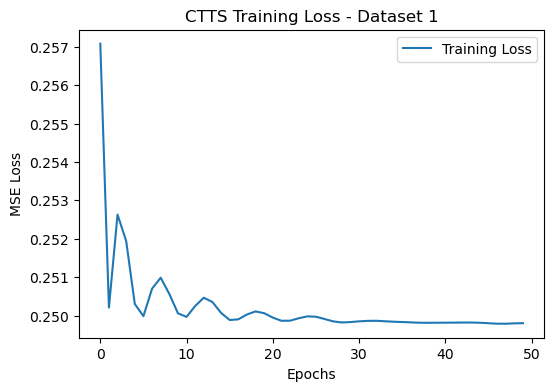

Accuracy:  0.505524861878453


/var/folders/31/b1v52j156gbfz83pmrnth3jc0000gn/T/ipykernel_27490/4167836627.py:58: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.argmax(torch.tensor(Y, dtype=torch.float32), dim=1)


In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
# import models.modules
from models.ctts import CTTS

# Load synthetic data
def load_synthetic_data(file_path, input_size=30):
    df = pd.read_csv(file_path)
    prices = df["Price"].values
    
    # Normalize data
    min_price, max_price = np.min(prices), np.max(prices)
    prices = (prices - min_price) / (max_price - min_price)

    # Prepare sequences
    X, Y = [], []
    for i in range(len(prices) - input_size):
        X.append(prices[i:i+input_size])
        if prices[i+input_size] > prices[i+input_size-1]:
            Y.append([1,0])
        # elif prices[i+input_size] == prices[i+input_size-1]:
        #     Y.append([0,1,0])
        else:
            Y.append([0,1])
    
    X, Y = np.array(X), np.array(Y)
    return torch.tensor(X, dtype=torch.float32).unsqueeze(1), torch.tensor(Y, dtype=torch.float32), min_price, max_price

# Training function
def train_ctts(model, X_train, Y_train, epochs=50, lr=0.001):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    optimizer = optim.Adam(model.parameters(), lr=lr)
    criterion = nn.MSELoss()

    losses = []
    X_train, Y_train = X_train.to(device), Y_train.to(device)

    for epoch in range(epochs):
        optimizer.zero_grad()
        preds = model(X_train).squeeze()
        loss = criterion(preds, Y_train)
        loss.backward()
        optimizer.step()
        losses.append(loss.item())

        if epoch % 10 == 0:
            print(f"Epoch {epoch}: Loss {loss.item():.4f}")

    return losses

def get_accuracy_rate(predictions, Y):
    predicted_classes = torch.argmax(torch.tensor(predictions, dtype=torch.float32), dim=1)
    labels = torch.argmax(torch.tensor(Y, dtype=torch.float32), dim=1)
    correct = (predicted_classes == labels).sum().item()
    total = labels.size(0)
    rate = correct / total
    return rate


# Prediction function
def evaluate_ctts(model, X_test, Y_test):
    model.eval()
    with torch.no_grad():
        preds = model(X_test.to(torch.device("cuda" if torch.cuda.is_available() else "cpu"))).cpu().numpy()
        
    return get_accuracy_rate(preds, Y_test)

# Load and train on 3 datasets
# file_paths = ["data/synthetic_series_1.csv", "data/synthetic_series_2.csv", "data/synthetic_series_3.csv"]
file_paths = ["data/synthetic/data/synthetic_series_1.csv"]
input_size = 30
epochs = 50

for idx, file_path in enumerate(file_paths):
    print(f"\n🔹 Training on {file_path} 🔹")

    # Load data
    X, Y, min_price, max_price = load_synthetic_data(file_path, input_size)

    # Split into train & test (90% train, 10% test)
    split_idx = int(len(X) * 0.9)
    X_train, Y_train = X[:split_idx], Y[:split_idx]
    X_test, Y_test = X[split_idx:], Y[split_idx:]

    # Initialize & train model
    model = CTTS(input_channels=1, 
                 cnn_kernel_size=5,
                 cnn_out_channels=64,
                 transformer_dim=128,
                 nhead=4,
                 num_layers=2,
                 num_classes=2)
    losses = train_ctts(model, X_train, Y_train, epochs=epochs)

    # Plot training loss
    plt.figure(figsize=(6, 4))
    plt.plot(losses, label="Training Loss")
    plt.xlabel("Epochs")
    plt.ylabel("MSE Loss")
    plt.title(f"CTTS Training Loss - Dataset {idx+1}")
    plt.legend()
    plt.show()

    # Evaluate model
    accuracy = evaluate_ctts(model, X_test, Y_test)
    print('Accuracy: ', accuracy)

    # Plot actual vs predicted
    # plt.figure(figsize=(8, 4))
    # plt.plot(Y_test.numpy() * (max_price - min_price) + min_price, label="Actual", linestyle="dashed")
    # plt.plot(predictions, label="Predicted", alpha=0.7)
    # plt.title(f"CTTS Predictions - Dataset {idx+1}")
    # plt.legend()
    # plt.show()


In [34]:
accuracy = evaluate_ctts(model, X_train, Y_train)
print('Accuracy: ', accuracy)

Accuracy:  0.514426028238183


/var/folders/5z/w98g0m1n1vx0kdz0jstg54j00000gn/T/ipykernel_62272/4167836627.py:58: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.argmax(torch.tensor(Y, dtype=torch.float32), dim=1)


In [39]:
labels = torch.argmax(torch.tensor(Y, dtype=torch.float32), dim=1).numpy()
unique, counts = np.unique(labels, return_counts=True)
counts = dict(zip(unique, counts))
print('Up', counts[0]/len(labels))
print('Down', counts[1]/len(labels))

Up 0.4972375690607735
Down 0.5027624309392266


/var/folders/5z/w98g0m1n1vx0kdz0jstg54j00000gn/T/ipykernel_62272/1779486080.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.argmax(torch.tensor(Y, dtype=torch.float32), dim=1).numpy()


### Temporal Fusion Transformer (TFT)

In [ ]:
predictions = evaluate_ctts(model, X_test, min_price, max_price)

# Plot actual vs predicted
plt.figure(figsize=(8, 4))
plt.plot(Y_test.numpy() * (max_price - min_price) + min_price, label="Actual", linestyle="dashed")
plt.plot(predictions, label="Predicted", alpha=0.7)
plt.title(f"CTTS Predictions - Dataset {idx+1}")
plt.legend()
plt.show()


In [ ]:
predictions

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, TensorDataset
from models.tft import TemporalFusionTransformer  # Ensure your model is correctly implemented

# Load synthetic data
df = pd.read_csv("data/synthetic_series_2.csv", parse_dates=["Date"])
prices = df["Price"].values

# Hyperparameters
input_size = 30  # Sequence length
batch_size = 16
epochs = 50
lr = 0.001

# Prepare dataset
X_train = [prices[i:i+input_size] for i in range(len(prices) - input_size)]
Y_train = [prices[i+input_size] for i in range(len(prices) - input_size)]

X_train = torch.tensor(X_train, dtype=torch.float32).unsqueeze(-1)  # Add feature dim (batch, seq_len, input_dim)
Y_train = torch.tensor(Y_train, dtype=torch.float32).unsqueeze(1)   # Make target shape (batch, 1)

# DataLoader for batching
train_dataset = TensorDataset(X_train, Y_train)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# Model setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = TemporalFusionTransformer(input_size=1, hidden_units=64, num_heads=4, num_layers=2, output_size=1).to(device)

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=lr)

# Training loop
losses = []
for epoch in range(epochs):
    model.train()
    epoch_loss = 0
    for X_batch, Y_batch in train_loader:
        X_batch, Y_batch = X_batch.to(device), Y_batch.to(device)

        optimizer.zero_grad()
        preds = model(X_batch).squeeze()
        loss = criterion(preds, Y_batch)
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()

    losses.append(epoch_loss / len(train_loader))
    
    if epoch % 10 == 0:
        print(f"Epoch {epoch}, Loss: {losses[-1]:.4f}")

# Plot training loss
plt.figure(figsize=(8, 4))
plt.plot(losses, label="Loss", color="blue")
plt.xlabel("Epochs")
plt.ylabel("MSE Loss")
plt.title("TFT Training Loss")
plt.legend()
plt.show()

# Generate test predictions
model.eval()
with torch.no_grad():
    test_preds = model(X_train.to(device)).cpu().numpy()

# Plot results
plt.figure(figsize=(10, 5))
plt.plot(Y_train.numpy(), label="Actual Price", linestyle="dashed", color="black")
plt.plot(test_preds, label="Predicted Price", color="red", alpha=0.7)
plt.xlabel("Time Steps")
plt.ylabel("Stock Price")
plt.title("TFT Predictions on Synthetic Data")
plt.legend()
plt.show()


/opt/anaconda3/envs/finance/lib/python3.13/site-packages/torch/nn/modules/transformer.py:385: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Epoch 0, Loss: 0.1876
Epoch 10, Loss: 0.0007
Epoch 20, Loss: 0.0006
Epoch 30, Loss: 0.0005
Epoch 40, Loss: 0.0006


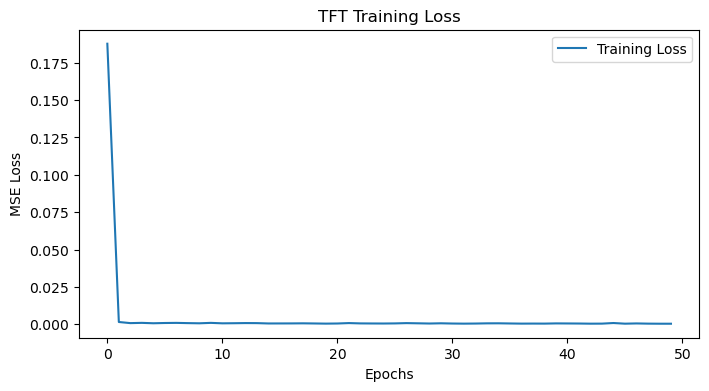

In [17]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from torch.utils.data import DataLoader, TensorDataset
from models.tft import TemporalFusionTransformer  # Your TFT model path

# 🔹 Load and normalize synthetic data
df = pd.read_csv("data/synthetic/data/synthetic_series_12.csv", parse_dates=["Date"])
prices = df["Price"].values.reshape(-1, 1)

scaler = MinMaxScaler()
prices_scaled = scaler.fit_transform(prices).flatten()

# 🔹 Hyperparameters
input_size = 30
forecast_horizon = 1
batch_size = 16
epochs = 50
lr = 0.001

# 🔹 Prepare sequences
X_train = [prices_scaled[i:i+input_size] for i in range(len(prices_scaled) - input_size - forecast_horizon)]
Y_train = [prices_scaled[i+input_size:i+input_size+forecast_horizon] for i in range(len(prices_scaled) - input_size - forecast_horizon)]

X_train = torch.tensor(X_train, dtype=torch.float32).unsqueeze(-1)  # (B, seq_len, 1)
Y_train = torch.tensor(Y_train, dtype=torch.float32)                # (B, 1)

# 🔹 Dummy exogenous and static data
exog_size = 3
static_size = 2
exog_dummy = torch.zeros(X_train.size(0), X_train.size(1), exog_size)
static_dummy = torch.zeros(X_train.size(0), static_size)

# 🔹 90/10 train-test split
split_idx = int(len(X_train) * 0.9)
X_train_data, X_test_data = X_train[:split_idx], X_train[split_idx:]
Y_train_data, Y_test_data = Y_train[:split_idx], Y_train[split_idx:]
exog_train, exog_test = exog_dummy[:split_idx], exog_dummy[split_idx:]
static_train, static_test = static_dummy[:split_idx], static_dummy[split_idx:]

# 🔹 DataLoader (Train only)
train_dataset = TensorDataset(X_train_data, Y_train_data, exog_train, static_train)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# 🔹 Initialize model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = TemporalFusionTransformer(
    input_size=1,
    exog_size=exog_size,
    static_size=static_size,
    hidden_units=64,
    num_heads=4,
    num_layers=2,
    output_size=forecast_horizon
).to(device)

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=lr)

# 🔹 Training loop
losses = []
for epoch in range(epochs):
    model.train()
    epoch_loss = 0
    for x_batch, y_batch, exog_batch, static_batch in train_loader:
        x_batch, y_batch = x_batch.to(device), y_batch.to(device)
        exog_batch, static_batch = exog_batch.to(device), static_batch.to(device)

        optimizer.zero_grad()
        preds = model(x_batch, exog=exog_batch, static=static_batch).squeeze()
        loss = criterion(preds, y_batch.squeeze())
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

    avg_loss = epoch_loss / len(train_loader)
    losses.append(avg_loss)
    if epoch % 10 == 0:
        print(f"Epoch {epoch}, Loss: {avg_loss:.4f}")

# 🔹 Plot training loss
plt.figure(figsize=(8, 4))
plt.plot(losses, label="Training Loss")
plt.xlabel("Epochs")
plt.ylabel("MSE Loss")
plt.title("TFT Training Loss")
plt.legend()
plt.show()

# # 🔹 Evaluate on full set (train + test)
# model.eval()
# with torch.no_grad():
#     train_preds = model(X_train_data.to(device), exog=exog_train.to(device), static=static_train.to(device)).cpu().numpy()
#     test_preds = model(X_test_data.to(device), exog=exog_test.to(device), static=static_test.to(device)).cpu().numpy()

# # 🔹 Inverse scale
# Y_actual_full = scaler.inverse_transform(torch.cat([Y_train_data, Y_test_data]).numpy().reshape(-1, 1)).flatten()
# Y_preds_full = scaler.inverse_transform(np.concatenate([train_preds, test_preds]).reshape(-1, 1)).flatten()

# # 🔹 Plot full prediction
# plt.figure(figsize=(12, 6))
# plt.plot(Y_actual_full, label="Actual", linestyle="dashed", color="black")
# plt.plot(Y_preds_full, label="Predicted", color="red", alpha=0.7)
# plt.axvline(x=split_idx, color="blue", linestyle="--", label="Train/Test Split")
# plt.xlabel("Time Steps")
# plt.ylabel("Stock Price")
# plt.title("TFT Full Forecast on Synthetic Data")
# plt.legend()
# plt.tight_layout()
# plt.show()



📊 Training Metrics
  MAE:  3.2003
  R²:   0.9760

📊 Testing Metrics
  MAE:  5.0386
  R²:   0.9529


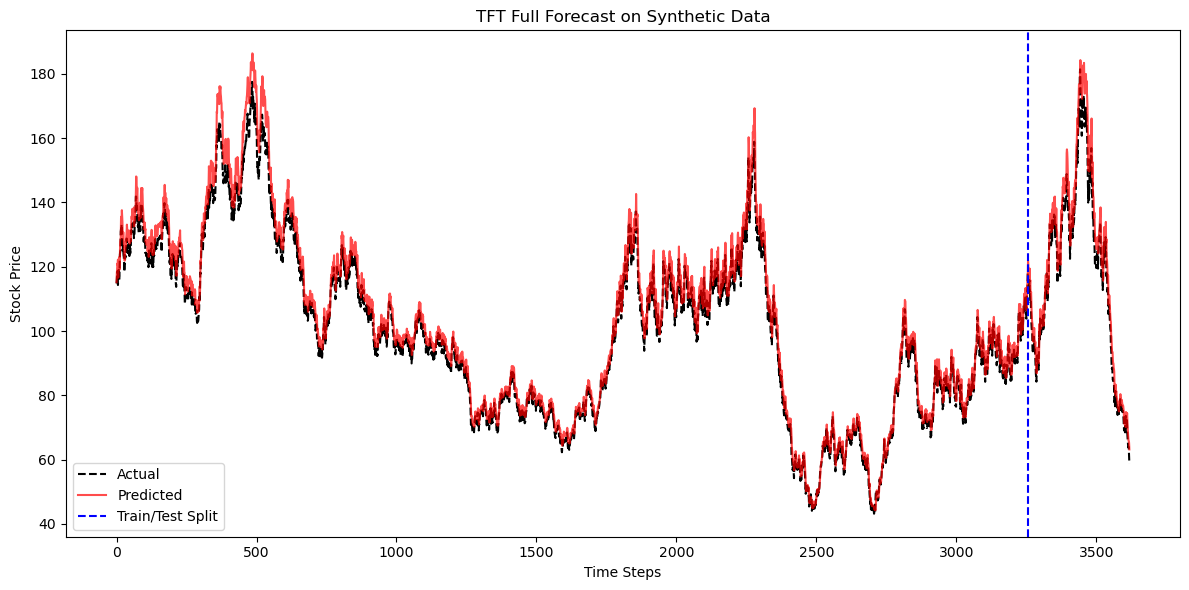

In [18]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# 🔹 Evaluate on full set (train + test)
model.eval()
with torch.no_grad():
    train_preds = model(X_train_data.to(device), exog=exog_train.to(device), static=static_train.to(device)).cpu().numpy()
    test_preds = model(X_test_data.to(device), exog=exog_test.to(device), static=static_test.to(device)).cpu().numpy()

# 🔹 Inverse scale predictions and actuals
Y_train_actual = scaler.inverse_transform(Y_train_data.numpy().reshape(-1, 1)).flatten()
Y_test_actual = scaler.inverse_transform(Y_test_data.numpy().reshape(-1, 1)).flatten()
Y_train_pred = scaler.inverse_transform(train_preds.reshape(-1, 1)).flatten()
Y_test_pred = scaler.inverse_transform(test_preds.reshape(-1, 1)).flatten()

# 🔹 Metrics
def print_metrics(name, y_true, y_pred):
    print(f"\n📊 {name} Metrics")
    print(f"  MAE:  {mean_absolute_error(y_true, y_pred):.4f}")
    # print(f"  RMSE: {mean_squared_error(y_true, y_pred, squared=False):.4f}")
    print(f"  R²:   {r2_score(y_true, y_pred):.4f}")

print_metrics("Training", Y_train_actual, Y_train_pred)
print_metrics("Testing", Y_test_actual, Y_test_pred)

# 🔹 Plot full prediction
Y_actual_full = np.concatenate([Y_train_actual, Y_test_actual])
Y_preds_full = np.concatenate([Y_train_pred, Y_test_pred])

plt.figure(figsize=(12, 6))
plt.plot(Y_actual_full, label="Actual", linestyle="dashed", color="black")
plt.plot(Y_preds_full, label="Predicted", color="red", alpha=0.7)
plt.axvline(x=split_idx, color="blue", linestyle="--", label="Train/Test Split")
plt.xlabel("Time Steps")
plt.ylabel("Stock Price")
plt.title("TFT Full Forecast on Synthetic Data")
plt.legend()
plt.tight_layout()
plt.show()


### DeepAR Model (Autoregressive RNN)

### old

In [ ]:
import importlib
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from models.deepar import DeepAR  # Import your DeepAR model
import models
importlib.reload(models)

# Set device
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 📌 Load Synthetic Data (3 CSVs
# 📌 Data Preparation (Convert to Sequences)
def create_sequences(prices, seq_length=30):
    X, Y = [], []
    for i in range(len(prices) - seq_length):
        X.append(prices[i : i + seq_length])
        Y.append(prices[i + seq_length])
    return np.array(X), np.array(Y)

# Select **1st synthetic series** for training
selected_series = datasets[0]["Price"].values

# Generate sequences
seq_length = 30
X_train, Y_train = create_sequences(selected_series, seq_length)

# Convert to PyTorch tensors
X_train = torch.tensor(X_train, dtype=torch.float32)  # (batch, seq_len, input_size)
Y_train = torch.tensor(Y_train, dtype=torch.float32).unsqueeze(-1)  # (batch, 1)

# 📌 Initialize DeepAR Model
input_size = 30  # Single feature (price)
hidden_units = 64
model = models.deepar.DeepAR(input_size=input_size, hidden_units=hidden_units).to(DEVICE)

# 📌 Loss Function & Optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# 📌 Training Loop
epochs = 50
losses = []

for epoch in range(epochs):
    model.train()
    optimizer.zero_grad()

    preds = model(X_train.to(DEVICE))
    loss = criterion(preds.squeeze(), Y_train.to(DEVICE))
    
    loss.backward()
    optimizer.step()
    losses.append(loss.item())

    if epoch % 10 == 0:
        print(f"Epoch {epoch}/{epochs} - Loss: {loss.item():.4f}")

# 📌 Plot Training Loss
plt.figure(figsize=(8, 4))
plt.plot(losses, label="Loss", color="blue")
plt.xlabel("Epochs")
plt.ylabel("MSE Loss")
plt.title("DeepAR Training Loss")
plt.legend()
plt.show()

# 📌 Test Predictions
model.eval()
with torch.no_grad():
    test_preds = model(X_train.to(DEVICE)).cpu().numpy()

# 📌 Plot Actual vs. Predicted
plt.figure(figsize=(10, 5))
plt.plot(Y_train.numpy(), label="Actual Price", linestyle="dashed", color="black")
plt.plot(test_preds[:, -1], label="Predicted Price", color="red", alpha=0.7)
plt.xlabel("Time Steps")
plt.ylabel("Stock Price")
plt.title("DeepAR Predictions on Synthetic Data")
plt.legend()
plt.show()


### new

In [35]:
import pandas as pd
from gluonts.dataset.common import ListDataset

data_paths = ["data/synthetic/data/synthetic_series_1.csv", "data/synthetic/data/synthetic_series_2.csv", "data/synthetic/data/synthetic_series_3.csv"]
datasets = [pd.read_csv(file, parse_dates=["Date"]) for file in data_paths]
selected_series = datasets[0]["Price"].values
df = datasets[0]
df.Date = pd.to_datetime(df.Date)
df['time_idx'] = list(range(len(df)))
df['series']=0
# df.set_index("Date",drop=True, inplace=True)

# training_data = ListDataset(
#     [{"start": df.index[0], "target": df.Price[:"2018-12-10T00:00:00.000000"], }],
#     freq = "D"
# )

# test_data = ListDataset(
#     [{"start": df.index[0], "target": df.Price[:"2019-12-29T00:00:00.000000"]}],
#     freq = "D"
# )
df[3500:]

,Date,Price,time_idx,series
3500,2019-08-02,148.172393,3500,0
3501,2019-08-03,149.456043,3501,0
3502,2019-08-04,148.976861,3502,0
3503,2019-08-05,149.969899,3503,0
3504,2019-08-06,145.001409,3504,0
...,...,...,...,...
3645,2019-12-25,79.095711,3645,0
3646,2019-12-26,79.843270,3646,0
3647,2019-12-27,79.211044,3647,0
3648,2019-12-28,80.288030,3648,0


In [26]:
from gluonts.torch.model.deepar import DeepAREstimator
from gluonts.dataset.common import ListDataset
from gluonts.dataset.field_names import FieldName
from gluonts.evaluation.backtest import make_evaluation_predictions
from tqdm.autonotebook import tqdm
from gluonts.evaluation import Evaluator

estimator = DeepAREstimator(
    freq="D",
    prediction_length=1,
    context_length=30,
    num_layers=2,
    dropout_rate=0.2,
    trainer_kwargs={'max_epochs': 16}
    # num_cells = 40,
    # distr_output=StudentTOutput(),
    # dropout_rate=0.01,
    # trainer=Trainer(#ctx = mx.context.gpu(),
    #                 epochs=500,
    #                 callbacks=callbacks)
)

predictor = estimator.train(training_data)

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


NotImplementedError: The operator 'aten::_standard_gamma' is not currently implemented for the MPS device. If you want this op to be added in priority during the prototype phase of this feature, please comment on https://github.com/pytorch/pytorch/issues/77764. As a temporary fix, you can set the environment variable `PYTORCH_ENABLE_MPS_FALLBACK=1` to use the CPU as a fallback for this op. WARNING: this will be slower than running natively on MPS.

In [ ]:
forecast_it, ts_it = make_evaluation_predictions(
    dataset=test_data,  # test dataset
    predictor=predictor,  # predictor
    num_samples=100,  # number of sample paths we want for evaluation
)

evaluator = Evaluator(quantiles=[0.1, 0.5, 0.9])
agg_metrics, item_metrics = evaluator(ts_it, forecast_it, num_series=len(test_data))
item_metrics

In [ ]:
forecast_it, ts_it = make_evaluation_predictions(
    dataset=test_data,  # test dataset
    predictor=predictor,  # predictor
    num_samples=100,  # number of sample paths we want for evaluation
)
# forecast_it.plot()
print(forecast_it)
# print(next(forecast_it))

forecasts = list(forecast_it)
tss = list(ts_it)
print(forecasts, tss)
ts_entry = tss[0]
forecast_entry = forecasts[0]
def plot_prob_forecasts(ts_entry, forecast_entry):
    plot_length = 150
    prediction_intervals = (50.0, 90.0)
    legend = ["observations", "median prediction"] + [f"{k}% prediction interval" for k in prediction_intervals][::-1]

    fig, ax = plt.subplots(1, 1, figsize=(10, 7))
    ts_entry[-plot_length:].plot(ax=ax)  # plot the time series
    forecast_entry.plot(prediction_intervals=prediction_intervals, color='g')
    plt.grid(which="both")
    plt.legend(legend, loc="upper left")
    plt.show()
plot_prob_forecasts(ts_entry, forecast_entry)


In [7]:
import warnings

warnings.filterwarnings("ignore")
import lightning.pytorch as pl
from lightning.pytorch.callbacks import EarlyStopping
import matplotlib.pyplot as plt
import pandas as pd
import torch

from pytorch_forecasting import Baseline, DeepAR, TimeSeriesDataSet
from pytorch_forecasting.data import NaNLabelEncoder
from pytorch_forecasting.data.examples import generate_ar_data
from pytorch_forecasting.metrics import MAE, SMAPE, MultivariateNormalDistributionLoss


In [8]:
!pip install pytorch_forecasting

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 197.7/197.7 kB 3.2 MB/s eta 0:00:00 0:00:01


In [91]:
# data_paths = ["data/synthetic/data/synthetic_series_1.csv", "data/synthetic/data/synthetic_series_2.csv", "data/synthetic/data/synthetic_series_3.csv"]
# datasets = [pd.read_csv(file, parse_dates=["Date"]) for file in data_paths]
# selected_series = datasets[0]["Price"].values
# df = datasets[0]
# df.Date = pd.to_datetime(df.Date)
# df.set_index("Date",drop=True, inplace=True)


df['static'] = 2
df['Price'].to_numpy()
df = df.astype(dict(series=str))
training = TimeSeriesDataSet(
    df[:3000],
    time_idx="time_idx",
    target="Price",
    categorical_encoders={"series": NaNLabelEncoder().fit(df.series)},
    group_ids=["series"],
    static_categoricals=[
        "series"
    ],  # as we plan to forecast correlations, it is important to use series characteristics (e.g. a series identifier)
    time_varying_unknown_reals=["Price"],
    max_encoder_length=30,
    max_prediction_length=1,
)
validation = TimeSeriesDataSet.from_dataset(training, df, min_prediction_idx=3000 + 1)
# validation = TimeSeriesDataSet.from_dataset(training, data, min_prediction_idx=training_cutoff + 1)
batch_size = 128
# synchronize samples in each batch over time - only necessary for DeepVAR, not for DeepAR
train_dataloader = training.to_dataloader(
    train=True, batch_size=batch_size, num_workers=0, batch_sampler="synchronized"
)
val_dataloader = validation.to_dataloader(
    train=False, batch_size=batch_size, num_workers=0, batch_sampler="synchronized"
)

In [93]:
df

,Date,Price,time_idx,series,static
0,2010-01-01,100.000000,0,0,2
1,2010-01-02,98.536001,1,0,2
2,2010-01-03,94.326009,2,0,2
3,2010-01-04,95.396956,3,0,2
4,2010-01-05,96.473079,4,0,2
...,...,...,...,...,...
3645,2019-12-25,79.095711,3645,0,2
3646,2019-12-26,79.843270,3646,0,2
3647,2019-12-27,79.211044,3647,0,2
3648,2019-12-28,80.288030,3648,0,2


In [105]:
pl.seed_everything(42)
import pytorch_forecasting as ptf

trainer = pl.Trainer(accelerator="cpu", gradient_clip_val=1e-1)
net = DeepAR.from_dataset(
    training,
    learning_rate=3e-2,
    hidden_size=30,
    rnn_layers=2,
    # loss=MultivariateNormalDistributionLoss(rank=30),
    optimizer="Adam",
)

Seed set to 42
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


In [97]:
# val_dataloader = validation.to_dataloader(
#     train=False, batch_size=batch_size, num_workers=0, batch_sampler="synchronized"
# )

Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=100` reached.
Learning rate set to 0.6309573444801929
Restoring states from the checkpoint path at /Users/Tanvi/bloomberg-time-series/.lr_find_39a2adc0-e1d9-4e33-b87e-b9e54bfb42f2.ckpt
Restored all states from the checkpoint at /Users/Tanvi/bloomberg-time-series/.lr_find_39a2adc0-e1d9-4e33-b87e-b9e54bfb42f2.ckpt


suggested learning rate: 0.6309573444801929


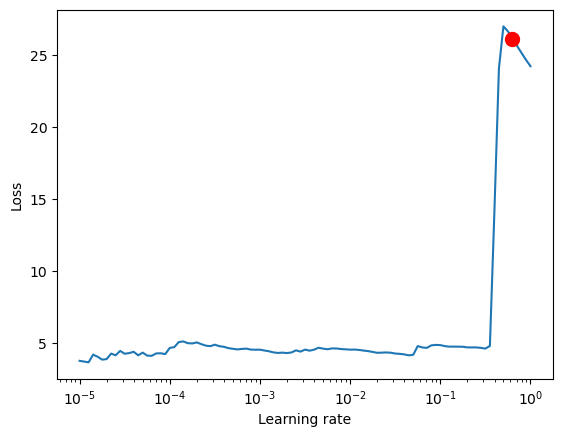

In [107]:

# find optimal learning rate
from lightning.pytorch.tuner import Tuner

res = Tuner(trainer).lr_find(
    net,
    train_dataloaders=train_dataloader,
    val_dataloaders=val_dataloader,
    min_lr=1e-5,
    max_lr=1e0,
    early_stop_threshold=500,
)
print(f"suggested learning rate: {res.suggestion()}")
fig = res.plot(show=True, suggest=True)
fig.show()
net.hparams.learning_rate = res.suggestion()

In [109]:
trainer.fit(
    net,
    train_dataloaders=train_dataloader,
    val_dataloaders=val_dataloader,
)



  | Name                   | Type                   | Params | Mode 
--------------------------------------------------------------------------
0 | loss                   | NormalDistributionLoss | 0      | train
1 | logging_metrics        | ModuleList             | 0      | train
2 | embeddings             | MultiEmbedding         | 1      | train
3 | rnn                    | LSTM                   | 11.5 K | train
4 | distribution_projector | Linear                 | 62     | train
--------------------------------------------------------------------------
11.6 K    Trainable params
0         Non-trainable params
11.6 K    Total params
0.046     Total estimated model params size (MB)
12        Modules in train mode
0         Modules in eval mode


Sanity Checking: |                                        | 0/? [00:00<?, ?it/s]

Training: |                                               | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

ValueError: Expected parameter loc (Tensor of shape (1, 1)) of distribution Normal(loc: tensor([[nan]], grad_fn=<SelectBackward0>), scale: tensor([[nan]], grad_fn=<SelectBackward0>)) to satisfy the constraint Real(), but found invalid values:
tensor([[nan]], grad_fn=<SelectBackward0>)

In [ ]:
best_model_path = trainer.checkpoint_callback.best_model_path
best_model = DeepAR.load_from_checkpoint(best_model_path)

In [ ]:
# best_model = net
predictions = best_model.predict(val_dataloader, trainer_kwargs=dict(accelerator="cpu"), return_y=True)
MAE()(predictions.output, predictions.y)

In [ ]:
raw_predictions = net.predict(
    val_dataloader, mode="raw", return_x=True, n_samples=100, trainer_kwargs=dict(accelerator="cpu")
)

In [ ]:
series = validation.x_to_index(raw_predictions.x)["series"]
for idx in range(2):  # plot 10 examples
    best_model.plot_prediction(raw_predictions.x, raw_predictions.output, idx=idx, add_loss_to_title=True)
    plt.suptitle(f"Series: {series.iloc[idx]}")